# 3D Image Segmentation with a 2D UNET

# 1) Imports and mount

In [1]:
%load_ext autoreload
%autoreload 2

# This sets up the appropriate logging and path configs
from notebook_setup import * 

In [2]:
import torch
from torchsummary import summary
import matplotlib.pyplot as plt

from monai.losses import DiceLoss
from src.features.build_features import train_transform, val_transform, test_transform

from src.visualization.visualize import view_slice

## 3.1) Sample Data

Get slices and save into a list dicts

In [3]:
from src.enums import INTERIM_TRAINING_DATA_PATHS, INTERIM_TESTING_DATA_PATHS
from src.pytorch_utils import get_interim_data_path

interim_train_paths = get_interim_data_path(INTERIM_TRAINING_DATA_PATHS)
interim_test_paths = get_interim_data_path(INTERIM_TESTING_DATA_PATHS)

## 3.3) Transforms

In [4]:
SEED = 2
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 64

## 3.5) Dataset and Dataloader

In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [47]:
train_paths = get_interim_data_path(INTERIM_TRAINING_DATA_PATHS)
val_paths = get_interim_data_path(INTERIM_TESTING_DATA_PATHS)

train_dataset  = Dataset(train_paths, train_transform)
validation_dataset  = Dataset(val_paths, val_transform)
test_dataset = Dataset(val_paths, test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE_VAL, shuffle=True)

In [7]:
from monai.transforms import LoadImaged

paths = [{
    DataDict.Id: 12,
    DataDict.Image: "data/interim/training/Singapore/51/Image/T1/brain_51-slice022_z.nii.gz",
    DataDict.ImageFlair:"data/interim/training/Singapore/51/Image/Flair/brain_51-slice022_z.nii.gz",
    DataDict.ImageT1: "data/interim/training/Singapore/51/Image/T1/brain_51-slice022_z.nii.gz",
    DataDict.Label:"data/interim/training/Singapore/51/Label/T1/brain_51-slice022_z.nii.gz",
    DataDict.DepthZ: 22
}]
test = Dataset(train_paths, train_transform)
train_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True, num_workers=2)

In [8]:

sample_data = test.__getitem__(20)

c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:494: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 2,please make sure the input is in the channel-first format.
  warnings.warn(


1920
tensor([[[1.8410e-04, 1.8410e-04, 1.8410e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.8410e-04, 1.8410e-04, 1.8410e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.8410e-04, 1.8410e-04, 1.8410e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [8.0834e-04, 8.0834e-04, 8.0834e-04,  ..., 5.5304e-05,
          5.5304e-05, 5.5304e-05],
         [8.0834e-04, 8.0834e-04, 8.0834e-04,  ..., 5.5304e-05,
          5.5304e-05, 5.5304e-05],
         [8.0834e-04, 8.0834e-04, 8.0834e-04,  ..., 5.5304e-05,
          5.5304e-05, 5.5304e-05]]])

Shapes: 
Image torch.Size([2, 256, 256]) 
Flair torch.Size([1, 256, 256])
T1 torch.Size([1, 256, 256])
Label torch.Size([2, 256, 256])

T1: Min:0.0 Max: 0.44478482007980347


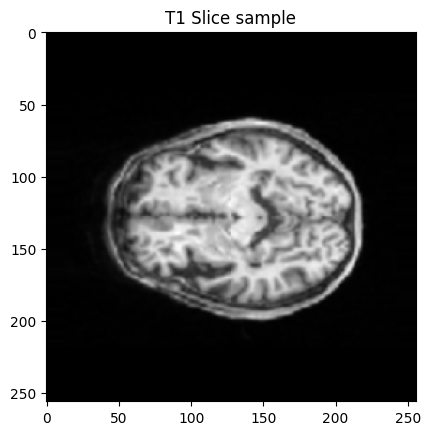

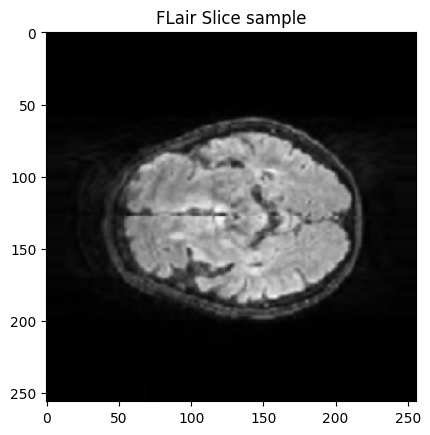

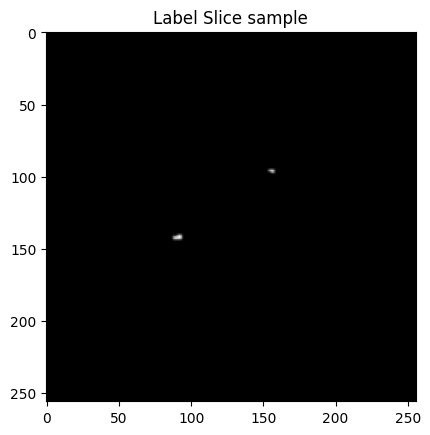

In [9]:


print(len(train_loader))

sample_data = test.__getitem__(20)
sample_tensor_image, sample_tensor_flair, sample_tensor_t1, sample_tensor_label = sample_data[DataDict.Image], sample_data[DataDict.ImageFlair], sample_data[DataDict.ImageT1], sample_data[DataDict.Label]

print(f'{sample_tensor_flair}\n')
print(f'Shapes: \nImage {sample_tensor_image.shape} \nFlair {sample_tensor_flair.shape}\nT1 {sample_tensor_t1.shape}\nLabel {sample_tensor_label.shape}\n')

print(f"T1: Min:{torch.min(sample_tensor_t1)} Max: {torch.max(sample_tensor_t1)}")

view_slice(sample_tensor_image[0].squeeze().detach().cpu(), "T1 Slice sample", True)
view_slice(sample_tensor_image[1].squeeze().detach().cpu(), "FLair Slice sample", True)
view_slice(sample_tensor_label[1].squeeze().detach().cpu(), "Label Slice sample", True)

Shapes: 
Image torch.Size([2, 256, 256]) 
Flair torch.Size([1, 256, 256])
T1 torch.Size([1, 256, 256])
Label torch.Size([2, 256, 256])


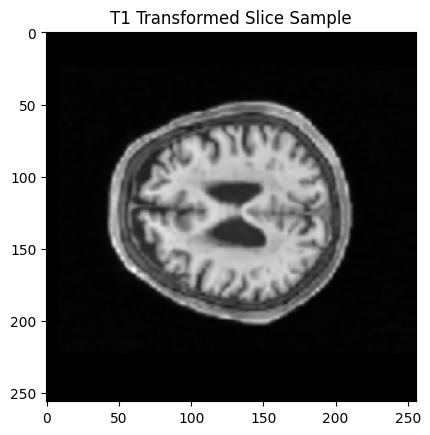

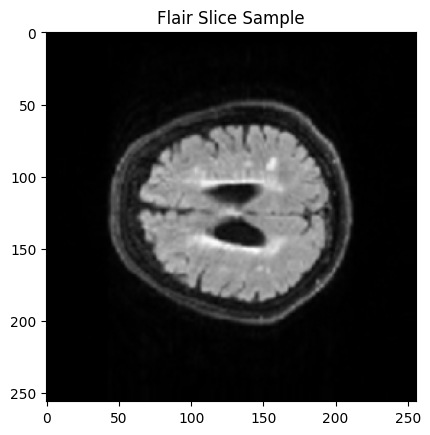

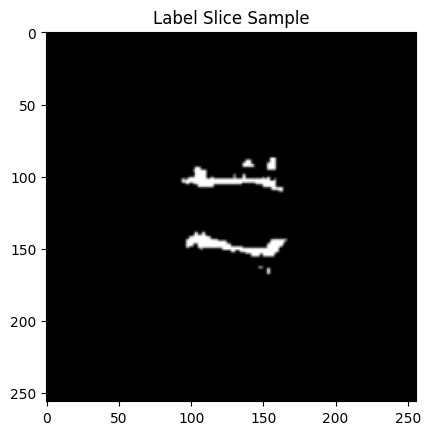

In [10]:
sample_data_2 = train_dataset.__getitem__(320)
sample_tensor_image2, sample_tensor_flair2, sample_tensor_t12, sample_tensor_label2 = sample_data_2[DataDict.Image], sample_data_2[DataDict.ImageFlair], sample_data_2[DataDict.ImageT1], sample_data_2[DataDict.Label]

print(f'Shapes: \nImage {sample_tensor_image2.shape} \nFlair {sample_tensor_flair2.shape}\nT1 {sample_tensor_t12.shape}\nLabel {sample_tensor_label2.shape}')
view_slice(sample_tensor_image2[0].squeeze().detach().cpu(), "T1 Transformed Slice Sample", True)
view_slice(sample_tensor_image2[1].squeeze().detach().cpu(), "Flair Slice Sample", True)
view_slice(sample_tensor_label2[1].squeeze().detach().cpu(), "Label Slice Sample", True)

# 4) Network

## 4.1) Train Network

## 4.3) Train data

In [13]:
from src.models.train_model import ModelTrainer, model, loss_function, optimizer, device
summary(model, (2, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             304
            Conv2d-2         [-1, 16, 128, 128]             304
    InstanceNorm2d-3         [-1, 16, 128, 128]               0
           Dropout-4         [-1, 16, 128, 128]               0
             PReLU-5         [-1, 16, 128, 128]               1
            Conv2d-6         [-1, 16, 128, 128]           2,320
    InstanceNorm2d-7         [-1, 16, 128, 128]               0
           Dropout-8         [-1, 16, 128, 128]               0
             PReLU-9         [-1, 16, 128, 128]               1
     ResidualUnit-10         [-1, 16, 128, 128]               0
           Conv2d-11           [-1, 32, 64, 64]           4,640
           Conv2d-12           [-1, 32, 64, 64]           4,640
   InstanceNorm2d-13           [-1, 32, 64, 64]               0
          Dropout-14           [-1, 32,

c:\Users\zifen\Documents\Projects\wmh-segmentation\src\models\neural_net_models.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [14]:
model_trainer = ModelTrainer(
        model,
        train_loader,
        validation_loader,
    loss_function, optimizer, device, 2000, False, ""
)
net = model_trainer.train_model()

 2023-12-23 13:52:01,975 - INFO - losses: {}
 2023-12-23 13:52:01,976 - INFO - val losses {}
 2023-12-23 13:52:09,745 - INFO - Epoch 0	Training Step: 1/1920
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\torch\_tensor.py:1386: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)
 2023-12-23 13:52:09,897 - INFO - Epoch 0	Training Step: 2/1920
 2023-12-23 13:52:09,997 - INFO - Epoch 0	Training Step: 3/1920
 2023-12-23 13:52:10,114 - INFO - Epoch 0	Training Step: 4/1920
 2023-12-23 13:52:10,214 - INFO - Epoch 0	Training Step: 5/1920
 2023-12-23 13:52:10,314 - INFO - Epoch 0	Training Step: 6/1920
 2023-12-23 13:52:10,414 - INFO - Epoch 0	Training Step: 7/1920
 2023-12-23 13:52:10,514 - INFO - Epoch 0	Training Step: 8/1920
 2023-12-23 13:52:10,614 - INFO - Epoch 0	Training Step: 9/1920
 2023-12-23 13:52:10,729 - INFO - Epoch 0	Training Step: 10/1920
 2023-12-23 13:52:

KeyboardInterrupt: 

# 5) Test network

In [15]:
# Load the network for testing
pred_network = model

checkpoint = torch.load('models/single_slice_t1_flair_v1.pt', map_location=torch.device('cpu'))
epoch_checkpoint = checkpoint['epoch']
losses = checkpoint['losses']
val_losses = checkpoint['val_losses']
pred_network.load_state_dict(checkpoint['model_state_dict'])

# print(checkpoint['model_state_dict'])
print(epoch_checkpoint)
print(losses)
print(val_losses)



413
{0: 0.6233169, 1: 0.6009359, 2: 0.58875245, 3: 0.57873124, 4: 0.57001907, 5: 0.5625568, 6: 0.55614454, 7: 0.5505168, 8: 0.54531723, 9: 0.540313, 10: 0.534805, 11: 0.52773863, 12: 0.51942563, 13: 0.5110327, 14: 0.5051068, 15: 0.50063014, 16: 0.49556315, 17: 0.4912256, 18: 0.48745945, 19: 0.48369727, 20: 0.48038015, 21: 0.47716114, 22: 0.47323546, 23: 0.46955952, 24: 0.46631345, 25: 0.46425438, 26: 0.4598975, 27: 0.4562563, 28: 0.45297328, 29: 0.4504048, 30: 0.44727048, 31: 0.44476578, 32: 0.44116664, 33: 0.43913487, 34: 0.436723, 35: 0.43393457, 36: 0.43151307, 37: 0.4284356, 38: 0.42671946, 39: 0.4242736, 40: 0.42306963, 41: 0.42174378, 42: 0.4178804, 43: 0.4164754, 44: 0.41513374, 45: 0.4147267, 46: 0.41267958, 47: 0.41021934, 48: 0.4084485, 49: 0.4073101, 50: 0.40543148, 51: 0.4035108, 52: 0.40463927, 53: 0.4032588, 54: 0.4005791, 55: 0.4001834, 56: 0.39903, 57: 0.3991489, 58: 0.39906025, 59: 0.39697325, 60: 0.39621043, 61: 0.39561367, 62: 0.39355302, 63: 0.39340973, 64: 0.393221

{0: 0.6233169, 1: 0.6009359, 2: 0.58875245, 3: 0.57873124, 4: 0.57001907, 5: 0.5625568, 6: 0.55614454, 7: 0.5505168, 8: 0.54531723, 9: 0.540313, 10: 0.534805, 11: 0.52773863, 12: 0.51942563, 13: 0.5110327, 14: 0.5051068, 15: 0.50063014, 16: 0.49556315, 17: 0.4912256, 18: 0.48745945, 19: 0.48369727, 20: 0.48038015, 21: 0.47716114, 22: 0.47323546, 23: 0.46955952, 24: 0.46631345, 25: 0.46425438, 26: 0.4598975, 27: 0.4562563, 28: 0.45297328, 29: 0.4504048, 30: 0.44727048, 31: 0.44476578, 32: 0.44116664, 33: 0.43913487, 34: 0.436723, 35: 0.43393457, 36: 0.43151307, 37: 0.4284356, 38: 0.42671946, 39: 0.4242736, 40: 0.42306963, 41: 0.42174378, 42: 0.4178804, 43: 0.4164754, 44: 0.41513374, 45: 0.4147267, 46: 0.41267958, 47: 0.41021934, 48: 0.4084485, 49: 0.4073101, 50: 0.40543148, 51: 0.4035108, 52: 0.40463927, 53: 0.4032588, 54: 0.4005791, 55: 0.4001834, 56: 0.39903, 57: 0.3991489, 58: 0.39906025, 59: 0.39697325, 60: 0.39621043, 61: 0.39561367, 62: 0.39355302, 63: 0.39340973, 64: 0.39322177, 

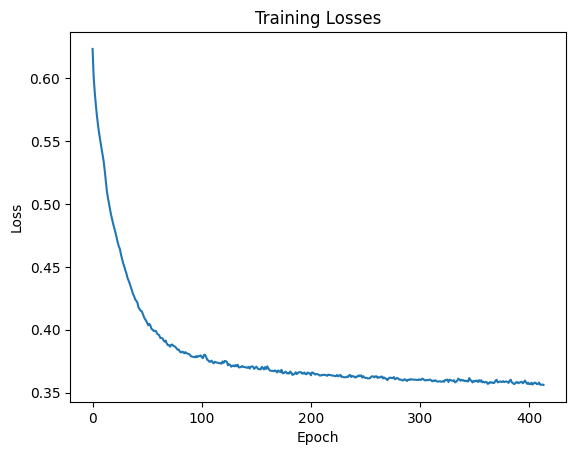

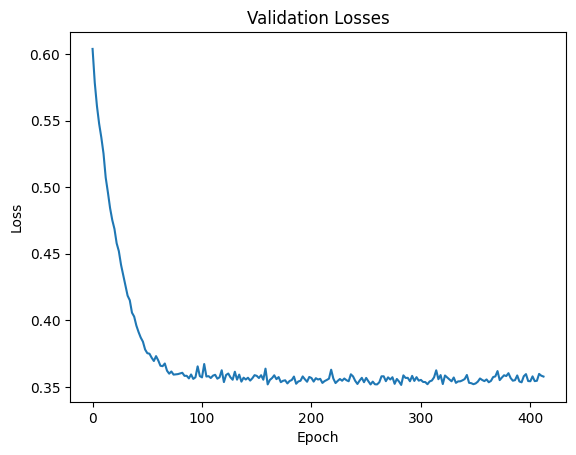

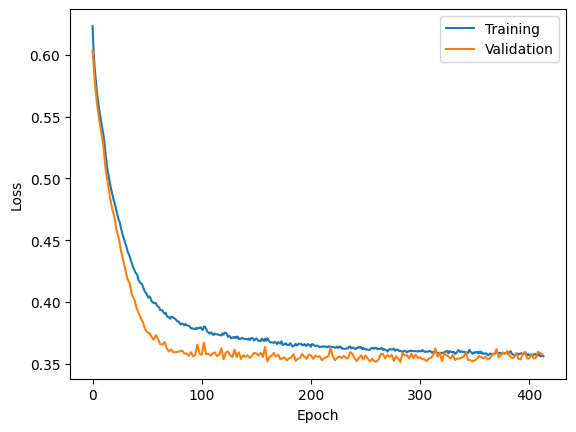

In [16]:
from src.pytorch_utils import dict_tensor_to_value
print(losses)
print(val_losses)


# Plot the validation and training losses
print(val_losses)
val_tensors = dict_tensor_to_value(val_losses)
print(val_tensors)

training_losses = sorted(losses.items()) # sorted by key, return a list of tuples
x, y = zip(*training_losses) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

validation_losses = sorted(val_tensors.items())
x2, y2 = zip(*validation_losses) # unpack a list of pairs into two tuples

plt.plot(x2, y2)
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(x, y, label = "Training")
plt.plot(x2, y2, label = "Validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
from torchvision import models
from torchsummary import summary

summary(pred_network, (2, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             304
            Conv2d-2         [-1, 16, 128, 128]             304
    InstanceNorm2d-3         [-1, 16, 128, 128]               0
           Dropout-4         [-1, 16, 128, 128]               0
             PReLU-5         [-1, 16, 128, 128]               1
            Conv2d-6         [-1, 16, 128, 128]           2,320
    InstanceNorm2d-7         [-1, 16, 128, 128]               0
           Dropout-8         [-1, 16, 128, 128]               0
             PReLU-9         [-1, 16, 128, 128]               1
     ResidualUnit-10         [-1, 16, 128, 128]               0
           Conv2d-11           [-1, 32, 64, 64]           4,640
           Conv2d-12           [-1, 32, 64, 64]           4,640
   InstanceNorm2d-13           [-1, 32, 64, 64]               0
          Dropout-14           [-1, 32,

# 6) Test Whole Volume

In [22]:
from src.pytorch_utils import get_dicts_from_dicts, one_hot


class ImagePredictor():
    def __init__(self, model, dataset):
        self.model = model
        # Passed as 2D slices with information about depth for reconstruction
        self.dataset = dataset

    def predict(self):
        self.slice_predictions = []
        with torch.no_grad():
            self.model.eval()
            pred_count = 1

            for data in self.dataset:
                if pred_count == 1 or pred_count % 50 == 0 or pred_count == len(self.dataset):
                    print(f'Predicting {pred_count}/{len(self.dataset)} slices')
                image = data[DataDict.Image]
                label = data[DataDict.Label]
                subj_id = data[DataDict.Id]
                depth_z = data[DataDict.DepthZ]

                image = image.unsqueeze(dim=0)
                image = image.to(device)

                output = one_hot(self.model(image))

                self.slice_predictions.append({
                    DataDict.Id: subj_id,
                    DataDict.DepthZ: depth_z,
                    DataDict.Label: label,
                    DataDict.Prediction: output
                })

                # print(self.slice_predictions)

                pred_count += 1
                

    def predict_handler(self):
        # Predict all slices
        self.predict()
        self.volume_predictions = []

        subj_ids = list(set(list(v[DataDict.Id] for v in self.slice_predictions)))

        print(f'{len(subj_ids)} subjects to predict')
        pred_count = 1
        # For all subjects
        for subject_id in subj_ids:
            print(f'Reconstructing {pred_count}/{len(subj_ids)}')
            # Find all slice_predictions by subjects
            subject_predictions = get_dicts_from_dicts(self.slice_predictions, DataDict.Id, [subject_id])
          
            # Reconstruct volume by subject
            volume_prediction, volume_label = self.reconstruct(subject_predictions)
        
            self.volume_predictions.append({
                DataDict.Id: subject_id,
                DataDict.Prediction: volume_prediction,
                DataDict.Label: volume_label
            })

            pred_count += 1

        return self.volume_predictions

    def reconstruct(self, subj_predictions):
        # sorted_subbj_pred_by_depth = sorted(subj_predictions, key=itemgetter(DataDict.DepthZ))     
        z_length = len(subj_predictions)  
        prediction_volume = torch.zeros((256, 256, z_length))
        label_volume = torch.zeros((256, 256, z_length))
        subj_id = subj_predictions[0][DataDict.Id]

        for i in range(z_length):
            # only take second channel
            if subj_predictions[i][DataDict.DepthZ] != i:
                raise ValueError("Reconstruction error: Slice missing") 

            subj_slice = subj_predictions[i] 
            # print(f'slice prediction {subj_slice[DataDict.Prediction].shape}')
            # print(f'slice label {subj_slice[DataDict.Label].shape}')
            prediction_volume[..., i] = subj_slice[DataDict.Prediction][0, 1, ...]
            label_volume[..., i] = subj_slice[DataDict.Label][1]

        return prediction_volume, label_volume

In [23]:
# test_datasaet
img_predictor = ImagePredictor(pred_network, test_dataset)
test_predictions = img_predictor.predict_handler()
print('DONE')

Predicting 1/2880 slices
Predicting 50/2880 slices
Predicting 100/2880 slices
Predicting 150/2880 slices
Predicting 200/2880 slices
Predicting 250/2880 slices
Predicting 300/2880 slices
Predicting 350/2880 slices
Predicting 400/2880 slices
Predicting 450/2880 slices
Predicting 500/2880 slices
Predicting 550/2880 slices
Predicting 600/2880 slices
Predicting 650/2880 slices
Predicting 700/2880 slices
Predicting 750/2880 slices
Predicting 800/2880 slices
Predicting 850/2880 slices
Predicting 900/2880 slices
Predicting 950/2880 slices
Predicting 1000/2880 slices
Predicting 1050/2880 slices
Predicting 1100/2880 slices
Predicting 1150/2880 slices
Predicting 1200/2880 slices
Predicting 1250/2880 slices
Predicting 1300/2880 slices
Predicting 1350/2880 slices
Predicting 1400/2880 slices
Predicting 1450/2880 slices
Predicting 1500/2880 slices
Predicting 1550/2880 slices
Predicting 1600/2880 slices
Predicting 1650/2880 slices
Predicting 1700/2880 slices
Predicting 1750/2880 slices
Predicting 1800

In [24]:
len(test_predictions)

60

In [26]:
# from monai.metrics import compute_meandice, DiceMetric

dice_scores = []

for i in range(len(test_predictions)):
    test_subject_prediction = test_predictions[i]

    print(test_subject_prediction[DataDict.Label].shape)
    print(test_subject_prediction[DataDict.Prediction].shape)

    pred = test_subject_prediction[DataDict.Prediction]
    label = test_subject_prediction[DataDict.Label]

    print(torch.max(pred))
    print(torch.min(pred))

    dice_metric = DiceLoss()
    # print(compute_meandice(pred, label))
    dice_score = 1 - dice_metric(pred, label)

    dice_scores.append(dice_score.item())


torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([

In [27]:
dice_scores


[0.9815140962600708,
 0.966586709022522,
 0.9902009963989258,
 0.9691082239151001,
 0.9058578610420227,
 0.9777428507804871,
 0.9894859790802002,
 0.9561915993690491,
 0.9678618907928467,
 0.9798822999000549,
 0.96888267993927,
 0.9897639751434326,
 0.9519736170768738,
 0.9784112572669983,
 0.9659574031829834,
 0.9520692825317383,
 0.9753952026367188,
 0.9364707469940186,
 0.9704351425170898,
 0.9867415428161621,
 0.9900296926498413,
 0.980666995048523,
 0.9729722142219543,
 0.9732721447944641,
 0.9844983220100403,
 0.9834015369415283,
 0.9848858714103699,
 0.9694156646728516,
 0.948653519153595,
 0.9798240661621094,
 0.9778563976287842,
 0.9741130471229553,
 0.9643986225128174,
 0.9934682250022888,
 0.9865897297859192,
 0.9918643832206726,
 0.9872784614562988,
 0.9612328410148621,
 0.9905246496200562,
 0.9800660014152527,
 0.9712381362915039,
 0.9762640595436096,
 0.983294665813446,
 0.9819896221160889,
 0.9602756500244141,
 0.975881040096283,
 0.973595917224884,
 0.9790866374969482,


In [28]:
from numpy import mean
mean_dice_score = round(mean(dice_scores), 5) 
mean_dice_score

0.9742

In [29]:
# view_slice(numpy_from_tensor(inputs[0, 0, :, :]), f'Input Channel 0 Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(inputs[0, 1, :, :]), f'Input Channel 1 Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(outputs[0, 1, :, :]), f'WMH Output Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(pred[..., 25]), f'WMH Pred', gray=True)
# view_slice(numpy_from_tensor(label[..., 25]), f'WMH Labels', gray=True)

w = 200
h = 200
fig = plt.figure(figsize=(200, 600))
fig.set_figheight(h)
fig.set_figwidth(w)
columns = 8
rows = 12

label_count = 0
pred_count = 0
row = 1

for i in range(1, columns * rows + 1):  
    fig.add_subplot(rows, columns, i)
    # Prediction row
    if row % 2 != 0:
        plt.subplot(rows, columns, i).set_title(f'Prediction Depth {pred_count}', fontweight="bold", size=80)
        plt.imshow(pred[..., pred_count], cmap='gray')
        pred_count += 1
    # Label row
    else:
        plt.subplot(rows, columns, i).set_title(f'Label Depth {label_count}', fontweight="bold", size=80)
        plt.imshow(label[..., label_count], cmap='gray')
        label_count += 1

    
    row += 1 if i % 8 == 0 else 0
plt.show()

In [38]:
test_dataset.__getitem__(0).keys()

c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:494: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 2,please make sure the input is in the channel-first format.
  warnings.warn(


dict_keys(['subj_id', 'image', 'img_flair', 'img_t1', 'label', 'depth_z'])

In [44]:
subject_data.get('img_t1').shape

torch.Size([1, 256, 256])

c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:494: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 2,please make sure the input is in the channel-first format.
  warnings.warn(


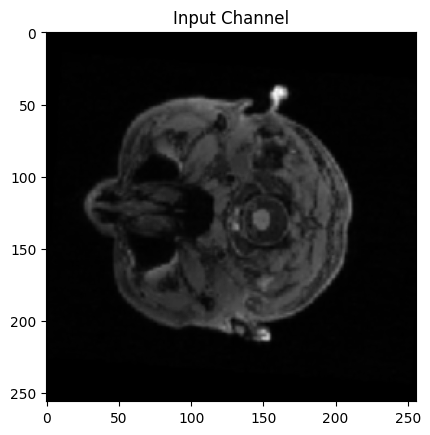

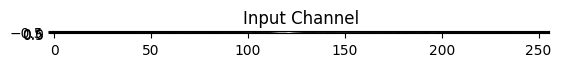

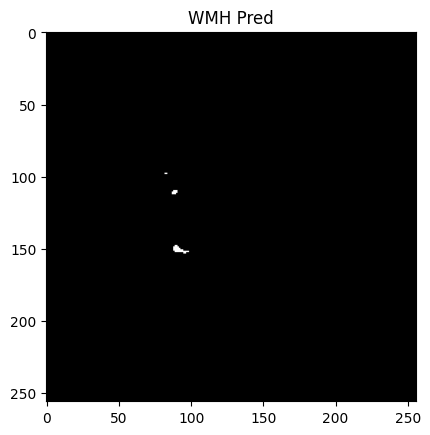

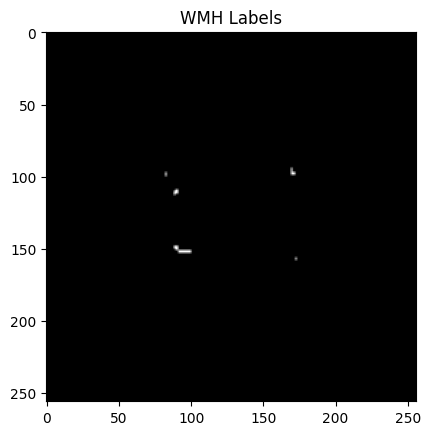

In [46]:
from src.pytorch_utils import numpy_from_tensor

subject_data = test_dataset.__getitem__(0)

view_slice(numpy_from_tensor(subject_data.get('img_t1')[0, ...]), f'Input Channel', gray=True)
view_slice(numpy_from_tensor(subject_data.get('img_flair')[..., 25]), f'Input Channel', gray=True)
view_slice(numpy_from_tensor(pred[..., 25]), f'WMH Pred', gray=True)
view_slice(numpy_from_tensor(label[..., 25]), f'WMH Labels', gray=True)